# A simple, yet complete, tutorial on how use the CCS_fit module to fit two-body interactions for solid Ne

In [1]:
# Load in the relevant packages

from ase.io import read,write
from ase.build import bulk
import numpy as np
import ase.db as db
from ase.visualize import view
from ase.calculators.lj import LennardJones
import matplotlib.pyplot as plt
from shutil import copyfile
from pymatgen.analysis import ewald
from ase.calculators.singlepoint import SinglePointCalculator
from pymatgen.core import Lattice, Structure

LJ=bulk('Ne','fcc',a=1.55)
LJ=LJ*[4,4,4]
calc_LJ = LennardJones()
LJ.calc = calc_LJ

charge_dict = {"Ne": +1}
LJ.charges = []
for elem in LJ.get_chemical_symbols():
    LJ.charges.append(charge_dict[elem])

Fit_on_forces=False  #Enable/disable option for fitting CCS potential to atomic forces. 

### Adding repulsive wall

In [2]:
orig_cell = LJ.get_cell()
orig_struc = LJ.copy()

displacement_magnitude=0.01
disp_steps=3
rounds=5

trainset_list="file_list" # List of strucutres to include in the database (see below)
f = open(trainset_list, "w")
counter=1
for round in range(rounds):
    for scale in np.linspace(0.9, 1.0, 11):
        new_cell = orig_cell*scale
        new_struc = orig_struc.copy()
        new_struc.charges = LJ.charges
        new_struc.set_cell(new_cell)
        new_struc.calc = calc_LJ
        nrg = new_struc.get_potential_energy()
        
        for i in range(disp_steps):
            rattle_struc = new_struc.copy()
            rattle_struc.charges = LJ.charges
            rattle_struc.rattle(displacement_magnitude*i, seed=counter)
            
            lattice = Lattice(rattle_struc.get_cell())
            coords = rattle_struc.get_scaled_positions()
            ew_struct = Structure(
                lattice,
                rattle_struc.get_chemical_symbols(),
                coords,
                site_properties={"charge": rattle_struc.charges},
            )
            Ew = ewald.EwaldSummation(ew_struct, compute_forces=True)
            ES_energy = Ew.total_energy
            ES_forces = Ew.forces
            
            rattle_struc.calc = calc_LJ
            F=rattle_struc.get_forces()
            E=rattle_struc.get_potential_energy()     

            calculator = SinglePointCalculator(
                rattle_struc, energy=(E+ES_energy), free_energy=(E+ES_energy), forces=(F+ES_forces)
            )
            rattle_struc.calc = calculator
            rattle_struc.get_potential_energy()
            rattle_struc.get_forces()
                       
            # if nrg < 0: # We exclude structures that are unreasonably high in energy
            xyz_file=f"CALCULATED_DATA/S{counter}.xyz"
            write(xyz_file,rattle_struc)
            print(xyz_file,file=f)
            counter += 1

f.close()

In [3]:
from ccs_fit.scripts.ccs_build_db import ccs_build_db

ccs_build_db(mode="CCS+Q",DFT_DB="LJ.db",file_list="file_list",overwrite=True)

    Building data-bases: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 165/165 [00:00<00:00, 221.78it/s]


In [4]:
from ccs_fit.scripts.ccs_fetch import ccs_fetch

charge_dict={"Ne":1.0}
ccs_fetch(mode="CCS+Q",DFT_DB="LJ.db", charge_dict=charge_dict, R_c=5., include_forces=Fit_on_forces)

    Fetching data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 165/165 [00:35<00:00,  4.63it/s]


In [5]:
### Generate input.json file
import json

input={
    "General": {
        "interface": "CCS+Q",
        "merging"  : "False",
        "separate_wall_opt": "True"
    },
    "Twobody": {
                "Ne-Ne": {
                        "Rcut": 5.0,
                        "Resolution": 0.02,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "full",
                        "range_width": 0.1,
                        "range_center": 1.39
                }
        }
}
#SAVE TO FILE
with open('CCS_input.json', 'w') as f:
    json.dump(input, f, indent=8)

In [1]:
#RUN FIT
from shutil import copyfile
from ccs_fit import ccs_fit

ccs_fit("CCS_input.json")

copyfile("CCS_params.json", "CCS_params_wall.json")

    Generating one-body information from training-set.
        Added elements:  ['Ne']
    Applying monotonic constraints for pair:  Ne-Ne


    Finding optimum switch: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 223/223 [00:15<00:00, 14.85it/s]


    The best switch is (193,) with rmse: 0.08624268084886971, corresponding to distances of [4.42] Å for element pairs ['Ne-Ne'].
[[ 4.31645474e+02]
 [ 3.27279582e+02]
 [ 2.36704626e+02]
 [ 1.69497164e+02]
 [ 1.20025875e+02]
 [ 8.55560364e+01]
 [ 5.86905207e+01]
 [ 4.14926933e+01]
 [ 2.38054153e+01]
 [ 1.83372601e+01]
 [ 9.49924019e+00]
 [ 4.22837140e+00]
 [ 5.30802173e-01]
 [-1.54656723e+00]
 [-3.25245333e+00]
 [-5.17726899e+00]
 [-5.48712428e+00]
 [-5.91808375e+00]
 [-5.91808358e+00]
 [-5.91808353e+00]
 [-5.63838429e+00]
 [-5.63838419e+00]
 [-5.00979431e+00]
 [-5.00979429e+00]
 [-5.00979428e+00]
 [-4.32090251e+00]
 [-3.81430967e+00]
 [-3.81430961e+00]
 [-3.81430947e+00]
 [-2.82663808e+00]
 [-2.82663807e+00]
 [-2.82663807e+00]
 [-2.82663806e+00]
 [-2.82663806e+00]
 [-2.10466104e+00]
 [-1.78226647e+00]
 [-1.78226647e+00]
 [-1.78226646e+00]
 [-1.78226645e+00]
 [-1.30707103e+00]
 [-1.30707099e+00]
 [-1.30707097e+00]
 [-1.30707096e+00]
 [-9.10792148e-01]
 [-9.10792144e-01]
 [-9.10792141e-

'CCS_params_wall.json'

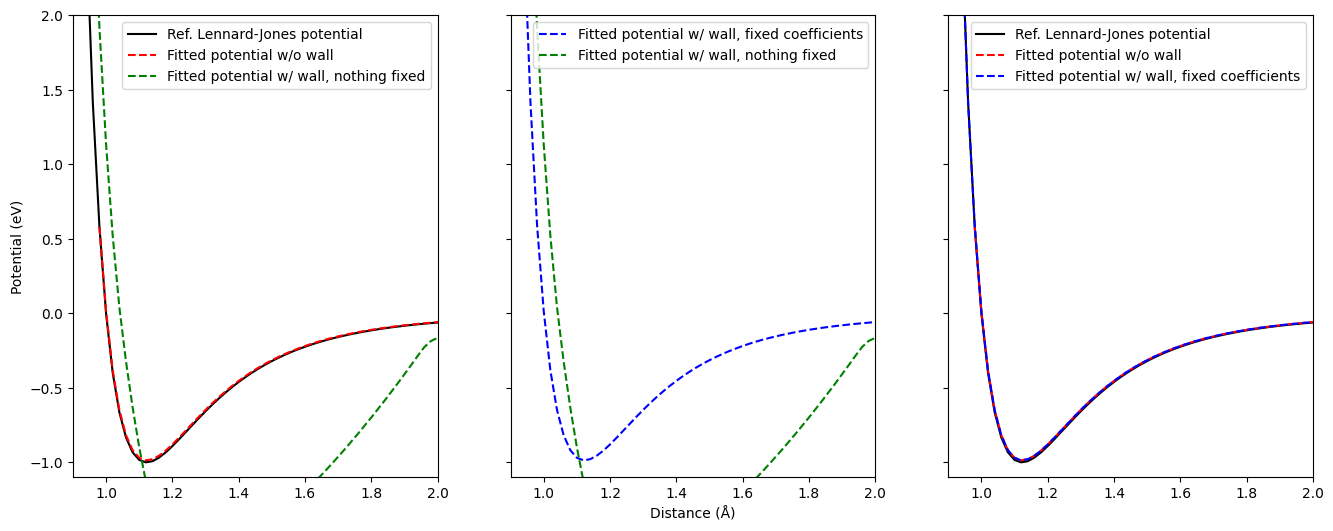

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt

with open("CCS_params_no_wall.json", "r") as f:
    CCS_params_no_wall = json.load(f)

with open("CCS_params_wall.json", "r") as f:
    CCS_params_wall = json.load(f)

with open("CCS_params_wall_nothing_fixed.json", "r") as f:
    CCS_params_wall_nothing_fixed = json.load(f)
    
r=np.array(CCS_params_no_wall["Two_body"]["Ne-Ne"]["r"])
r_wall=np.array(CCS_params_wall["Two_body"]["Ne-Ne"]["r"])
r_wall_nothing_fixed=np.array(CCS_params_wall_nothing_fixed["Two_body"]["Ne-Ne"]["r"])
e=CCS_params_no_wall["Two_body"]["Ne-Ne"]["spl_a"]
e_wall = CCS_params_wall["Two_body"]["Ne-Ne"]["spl_a"]
e_wall_nothing_fixed = CCS_params_wall_nothing_fixed["Two_body"]["Ne-Ne"]["spl_a"]
e_LJ= 4 * ((1 / r_wall) ** 12 - (1 / r_wall) ** 6)

fig, axs = plt.subplots(1, 3, sharey=True, sharex=True, figsize=(16,6))

axs[0].plot(r_wall,e_LJ,color='black',label="Ref. Lennard-Jones potential")
axs[0].plot(r,e,'--',color='red',label="Fitted potential w/o wall")
axs[0].plot(r_wall_nothing_fixed,e_wall_nothing_fixed,'--',color='green', label="Fitted potential w/ wall, nothing fixed")
axs[0].legend()

axs[1].plot(r_wall,e_wall,'--',color='blue',label="Fitted potential w/ wall, fixed coefficients")
axs[1].plot(r_wall_nothing_fixed,e_wall_nothing_fixed,'--',color='green',label="Fitted potential w/ wall, nothing fixed")
axs[1].legend()

axs[2].plot(r_wall,e_LJ,color='black',label="Ref. Lennard-Jones potential")
axs[2].plot(r,e,'--',color='red',label="Fitted potential w/o wall")
axs[2].plot(r_wall,e_wall,'--',color='blue',label="Fitted potential w/ wall, fixed coefficients")
axs[2].legend()

axs[0].set_xlim(0.9,2)
axs[0].set_ylim(-1.1, 2)
axs[1].set_xlabel('Distance (Å)')
axs[0].set_ylabel('Potential (eV)')


plt.show()